1. treat the sequences independent and fuse/concatenate the representations late (late fusion)?<br>
2. Or do you treat them as multi-channel input with each time series as a channel (early fusion)?<br>

late fusion is probably better because don't need to convern time seriers model and tabular data into the same format. 


Approaches: 
0. Include the data as part of the temporal data itself. So each feature vector at a particular timestep includes "mostly" time-series data, but then has the conditioning data appended to the end of each feature vector. Will the network learn to recognize this? Probably, but even then, you are creating a harder learning task by polluting the sequence data with non-sequential information. Also cost of higher loss / lower accuracy per training time. DISCOURAGE
1. introduce this sort of "extra" information into your model outside of the LSTM by means of additional layers. You might have a data flow like this:
TIME_SERIES_INPUT ------> LSTM -------\
                                       *---> MERGE ---> [more processing]
AUXILIARY_INPUTS --> [do something] --/
2. Be to directly affect the hidden state of the RNN at time zero. This is the approach taken by Karpathy and Fei-Fei and by Vinyals et al. This is how it works:
    a.For each training sample, take your condition variables x⃗.<br>
    b.Transform/reshape your condition variables with an affine transformation to get it into the right shape as the internal state of the RNN: v⃗ =Wx⃗ +b⃗  (these W and b⃗  are trainable weights). You can obtain it with a Dense layer in keras.<br>
    c.For the very first timestep, add v⃗  to the hidden state of the RNN when calculating its value.<br>

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import tensorflow 
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from pandas import read_csv
from pandas import datetime
from pandas import DataFrame
from pandas import concat
from keras.models import Sequential
from keras.layers import LSTM, Dense
from cond_rnn import ConditionalRNN
import tensorflow as tf
from numpy import asarray
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import mean_squared_error
import time

In [10]:
gateway = pd.read_csv('C:/Users/wanru/OneDrive - Ecolab/Desktop/tlm_analysis/data/processed/07-08-20-gateway-subset.csv')
controller = pd.read_csv('C:/Users/wanru/OneDrive - Ecolab/Desktop/tlm_analysis/data/processed/07-08-20-controller-subset.csv')
facility = pd.read_csv('C:/Users/wanru/OneDrive - Ecolab/Desktop/tlm_analysis/data/processed/07-08-20-facility-subset.csv')


In [8]:
controller.head()

,TankID,MeasurementDate,Value
0,30850,2018-05-13,72.727041
1,30850,2018-05-14,72.122089
2,30850,2018-05-15,71.485709
3,30850,2018-05-16,70.732294
4,30850,2018-05-17,70.232095


In [11]:
import copy
def _read_measurement_data(fpath):
    ddf = pd.read_csv(fpath)
    df = ddf.pivot(index="MeasurementDate", columns="TankID")
    df.columns = [x[1] for x in df.columns.values]
    df.index = df.index.astype("M8[ns]")
    return df.fillna(0)
def _transform_data(df_resampled: pd.DataFrame):
    """ Resamples the historical data for the tanks being modeled """
    df_differences = copy.copy(df_resampled.diff().fillna(0))
    df_differences[df_differences > 0.5] = 0
    return df_differences

In [12]:
controller_path='C:/Users/wanru/OneDrive - Ecolab/Desktop/tlm_analysis/data/processed/07-08-20-controller-subset.csv'
gateway_path = 'C:/Users/wanru/OneDrive - Ecolab/Desktop/tlm_analysis/data/processed/07-08-20-gateway-subset.csv'
CT = _read_measurement_data(controller_path)
GT = _read_measurement_data(gateway_path)    
CT_tank_ids = CT.columns
CT_resampled = CT.resample("D").mean().interpolate()
CT_features = _transform_data(CT_resampled)

GT_tank_ids = GT.columns
GT_resampled = GT.resample("D").mean().interpolate()
GT_features = _transform_data(GT_resampled)

In [5]:
CT.head()

,30850,30851,30852,34507,34508,38357,40281,40283,40284,40886,...,387131,387175,387183,387309,387310,387311,516817,517921,544779,544783
MeasurementDate,,,,,,,,,,,,,,,,,,,,,
2018-05-13,72.727041,0.0,126.283292,14.523067,26.139460,112.873592,6.616721,37.115531,20.037515,104.973610,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-05-14,72.122089,0.0,126.026284,14.508101,26.018659,109.080227,6.617597,37.156006,20.055234,104.949061,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-05-15,71.485709,0.0,125.898074,14.553999,25.884044,105.999240,6.570188,37.101036,20.133551,104.668376,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-05-16,70.732294,0.0,125.656935,14.565360,25.905252,105.595614,6.486963,36.990147,20.109675,106.022166,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-05-17,70.232095,0.0,125.644404,14.389215,25.759588,102.713006,6.430673,36.812192,20.119921,105.178605,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


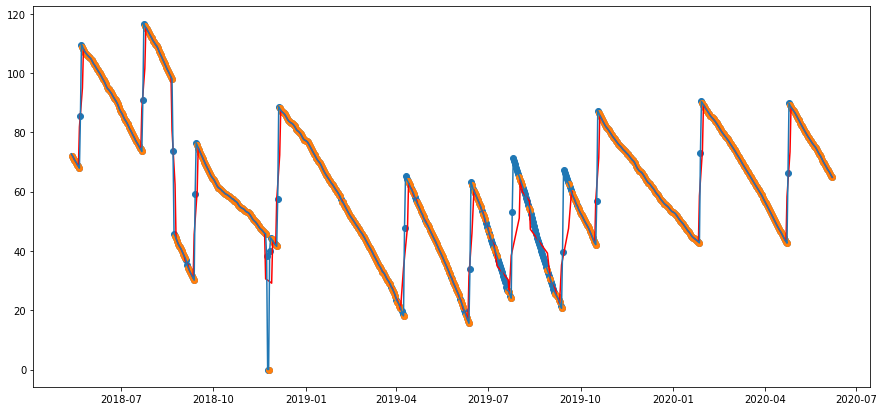

In [7]:
from scipy.signal import savgol_filter
p = 3
tank_id = 30850
plt.figure(figsize=(15, 7))
temp = CT[tank_id][np.abs(CT[tank_id].diff() - CT[tank_id].diff().mean()) < 10*CT[tank_id].diff().std()]
temp2 = CT[tank_id][np.abs(CT[tank_id].diff() - CT[tank_id].diff().mean()) < 0.2*CT[tank_id].diff().std()]
plt.scatter(temp.index.values.astype('M8[D]'), temp.values)
plt.scatter(temp2.index.values.astype('M8[D]'), temp2.values)
plt.plot(temp2.dropna().index.values.astype('M8[D]'), savgol_filter(temp2.dropna().values, p, 1), color='r')
plt.plot(CT[tank_id].index.values.astype('M8[D]'), CT[tank_id])

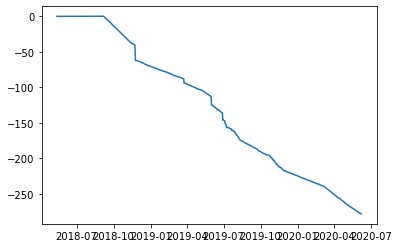

In [44]:
plt.plot(CT_features[30851].cumsum() + CT[30851].iloc[1] )


In [153]:
CT_features.head()

,30850,30851,30852,34507,34508,38357,40281,40283,40284,40886,...,387131,387175,387183,387309,387310,387311,516817,517921,544779,544783
MeasurementDate,,,,,,,,,,,,,,,,,,,,,
2018-05-13,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-05-14,-0.604951,0.0,-0.257007,-0.014966,0.0,-3.793365,0.000876,0.040475,0.017719,-0.024549,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-05-15,-0.636381,0.0,-0.128210,0.045898,0.0,-3.080986,-0.047409,-0.054970,0.078318,-0.280685,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-05-16,-0.753414,0.0,-0.241139,0.011361,0.0,-0.403627,-0.083224,-0.110889,-0.023876,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-05-17,-0.500199,0.0,-0.012531,-0.176145,0.0,-2.882608,-0.056290,-0.177955,0.010246,-0.843561,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [22]:
num_feature = 1
split = math.ceil(0.7*len(CT_features))
train_sequences = CT_features.iloc[0:split-42,].to_numpy() 
train_output_sequences = CT_features.iloc[split-42:split,].to_numpy()
train_y = np.reshape(train_output_sequences,(len(CT_features.columns),42) )
train_inputs = train_sequences.reshape((train_sequences.shape[1], train_sequences.shape[0], num_feature))

test_sequences = CT_features.iloc[split:-42,].to_numpy() 
test_output_sequences = CT_features.iloc[-42:,].to_numpy()
test_y = np.reshape(test_output_sequences,(len(CT_features.columns),42))
test_inputs = test_sequences.reshape((test_sequences.shape[1], test_sequences.shape[0], num_feature))

In [25]:
print(train_inputs.shape,train_y.shape)

(93, 488, 1) (93, 42)


In [26]:
print(test_inputs.shape,test_y.shape)

(93, 185, 1) (93, 42)


In [29]:
train_tanks = CT_features.iloc[0:split-42,].columns
test_tanks = CT_features.iloc[split:-42,].columns
train_geo = facility[facility['TankID'].isin(train_tanks)]['TankGeometry'].to_numpy().reshape(-1, 1)
test_geo = facility[facility['TankID'].isin(test_tanks)]['TankGeometry'].to_numpy().reshape(-1, 1)
print(train_geo.shape,test_geo.shape)

(93, 1) (93, 1)


In [40]:
# example of a ordinal encoding
# define ordinal encoding
encoder = OrdinalEncoder()
# transform data
train_result = np.transpose(encoder.fit_transform(train_geo).astype(np.int64))
train_cond = np.zeros((train_result.size, train_result.max()+1))
train_cond[np.arange(train_result.size),train_result] = 1
print(train_result.shape,train_cond.shape)

(1, 93) (93, 2)


In [37]:
test_result = np.transpose(encoder.fit_transform(test_geo).astype(np.int64))
print(test_result.shape)
test_cond = np.zeros((test_result.size, test_result.max()+1))
test_cond[np.arange(test_result.size),test_result] = 1
print(test_cond.shape)

(1, 93)
(93, 2)


In [38]:
train_inputs.shape

(93, 488, 1)

In [13]:
# test in random data 
train_inputs = np.random.random([10, 715, 1])
TankGeometry = np.random.random([10, 2])

In [25]:
class MySimpleModel(tf.keras.Model):
    def __init__(self):
        super(MySimpleModel, self).__init__()
        self.cond = ConditionalRNN(NUM_CELLS, cell='LSTM', dtype=tf.float32, return_sequences=True)
        self.cond2 = ConditionalRNN(NUM_CELLS, cell='LSTM', dtype=tf.float32, return_sequences=False)
        self.out = tf.keras.layers.Dense(units=2, activation='softmax')

    def call(self, inputs, **kwargs):
        x, cond = inputs
        o = self.cond([x, cond])
        o = self.cond2([o, cond])
        o = self.out(o)
        return o
NUM_CELLS = 6
model = MySimpleModel()

optimizer = tf.keras.optimizers.Adam(learning_rate=0.1)
model.call([train_inputs, train_cond])
model.compile(optimizer=optimizer, loss='mean_squared_error')
model.fit(x=[train_inputs, train_cond], y=train_y,
              validation_data=([test_inputs, test_cond], test_y),
              epochs=150)

#te_loss, te_acc = model.evaluate([test_inputs, cond_tankgeo], test_targets)
#assert abs(te_acc - 1) < 1e-5




If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Train on 10 samp

Epoch 67/150
10/10 [==============================] - 0s 38ms/sample - loss: 2.4898 - val_loss: 8.2540
Epoch 68/150
10/10 [==============================] - 0s 37ms/sample - loss: 2.4898 - val_loss: 8.2540
Epoch 69/150
10/10 [==============================] - 0s 39ms/sample - loss: 2.4898 - val_loss: 8.2540
Epoch 70/150
10/10 [==============================] - 0s 38ms/sample - loss: 2.4898 - val_loss: 8.2540
Epoch 71/150
10/10 [==============================] - 0s 38ms/sample - loss: 2.4898 - val_loss: 8.2540
Epoch 72/150
10/10 [==============================] - 0s 38ms/sample - loss: 2.4898 - val_loss: 8.2539
Epoch 73/150
10/10 [==============================] - 0s 37ms/sample - loss: 2.4898 - val_loss: 8.2539
Epoch 74/150
10/10 [==============================] - 0s 39ms/sample - loss: 2.4898 - val_loss: 8.2539
Epoch 75/150
10/10 [==============================] - 0s 41ms/sample - loss: 2.4898 - val_loss: 8.2539
Epoch 76/150
10/10 [==============================] - 0s 38ms/sample - lo

10/10 [==============================] - 0s 37ms/sample - loss: 2.4898 - val_loss: 8.2536
Epoch 147/150
10/10 [==============================] - 0s 39ms/sample - loss: 2.4898 - val_loss: 8.2536
Epoch 148/150
10/10 [==============================] - 0s 38ms/sample - loss: 2.4898 - val_loss: 8.2536
Epoch 149/150
10/10 [==============================] - 0s 38ms/sample - loss: 2.4898 - val_loss: 8.2536
Epoch 150/150
10/10 [==============================] - 0s 38ms/sample - loss: 2.4898 - val_loss: 8.2536


In [28]:
class MySimpleModel2(tf.keras.Model):
    def __init__(self):
        super(MySimpleModel2, self).__init__()
        self.cond = ConditionalRNN(NUM_CELLS, cell='GRU', dtype=tf.float32, return_sequences=True)
        self.cond2 = ConditionalRNN(NUM_CELLS, cell='GRU', dtype=tf.float32, return_sequences=False)
        self.out = tf.keras.layers.Dense(units=2, activation='softmax')

    def call(self, inputs, **kwargs):
        x, cond = inputs
        o = self.cond([x, cond])
        o = self.cond2([o, cond])
        o = self.out(o)
        return o
NUM_CELLS = 6
model = MySimpleModel2()

optimizer = tf.keras.optimizers.Adam(learning_rate=0.1)
model.call([train_inputs, train_cond])
model.compile(optimizer=optimizer, loss='mean_squared_error')
model.fit(x=[train_inputs, train_cond], y=train_y,
              validation_data=([test_inputs, test_cond], test_y),
              epochs=150)

#te_loss, te_acc = model.evaluate([test_inputs, cond_tankgeo], test_targets)
#assert abs(te_acc - 1) < 1e-5




If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Train on 10 samp

Epoch 67/150
10/10 [==============================] - 0s 43ms/sample - loss: 2.4898 - val_loss: 8.2491
Epoch 68/150
10/10 [==============================] - 0s 44ms/sample - loss: 2.4898 - val_loss: 8.2491
Epoch 69/150
10/10 [==============================] - 0s 43ms/sample - loss: 2.4898 - val_loss: 8.2491
Epoch 70/150
10/10 [==============================] - 0s 43ms/sample - loss: 2.4898 - val_loss: 8.2491
Epoch 71/150
10/10 [==============================] - 0s 43ms/sample - loss: 2.4898 - val_loss: 8.2491
Epoch 72/150
10/10 [==============================] - 0s 46ms/sample - loss: 2.4898 - val_loss: 8.2491
Epoch 73/150
10/10 [==============================] - 0s 43ms/sample - loss: 2.4898 - val_loss: 8.2491
Epoch 74/150
10/10 [==============================] - 0s 43ms/sample - loss: 2.4898 - val_loss: 8.2491
Epoch 75/150
10/10 [==============================] - 0s 43ms/sample - loss: 2.4898 - val_loss: 8.2491
Epoch 76/150
10/10 [==============================] - 0s 44ms/sample - lo

10/10 [==============================] - 0s 45ms/sample - loss: 2.4898 - val_loss: 8.2491
Epoch 147/150
10/10 [==============================] - 0s 45ms/sample - loss: 2.4898 - val_loss: 8.2491
Epoch 148/150
10/10 [==============================] - 1s 53ms/sample - loss: 2.4898 - val_loss: 8.2491
Epoch 149/150
10/10 [==============================] - 0s 47ms/sample - loss: 2.4898 - val_loss: 8.2491
Epoch 150/150
10/10 [==============================] - 0s 46ms/sample - loss: 2.4898 - val_loss: 8.2491


In [26]:
predict = model.predict([test_inputs, test_cond])
predict

array([[0.5116597 , 0.48834032],
       [0.5954258 , 0.40457422]], dtype=float32)

In [32]:
print(mean_squared_error(predict,test_y))

ValueError: y_true and y_pred have different number of output (2!=1)

In [49]:
#only time series feature
model = Sequential()
model.add(LSTM(256, return_sequences = True, input_shape = (train_inputs.shape[1], 1)))
model.add(LSTM(128,input_shape = (train_inputs.shape[1], 1)))
model.add(Dense(1))
model.compile(loss = 'mean_squared_error', optimizer = 'adam')
model.fit(train_inputs, train_y, epochs = 150, batch_size = 10, verbose = 2, shuffle = False)
model.save_weights('LSTMBasic1.h5')

Epoch 1/150
 - 2s - loss: 1.4835
Epoch 2/150
 - 1s - loss: 1.2236
Epoch 3/150
 - 1s - loss: 1.0500
Epoch 4/150
 - 1s - loss: 1.1465
Epoch 5/150
 - 1s - loss: 1.0601
Epoch 6/150
 - 1s - loss: 1.0380
Epoch 7/150
 - 1s - loss: 1.0572
Epoch 8/150
 - 1s - loss: 1.0741
Epoch 9/150
 - 1s - loss: 1.0780
Epoch 10/150
 - 2s - loss: 1.0705
Epoch 11/150
 - 1s - loss: 1.0563
Epoch 12/150
 - 1s - loss: 1.0421
Epoch 13/150
 - 2s - loss: 1.0353
Epoch 14/150
 - 2s - loss: 1.0404
Epoch 15/150
 - 2s - loss: 1.0492
Epoch 16/150
 - 2s - loss: 1.0465
Epoch 17/150
 - 2s - loss: 1.0354
Epoch 18/150
 - 2s - loss: 1.0280
Epoch 19/150
 - 2s - loss: 1.0276
Epoch 20/150
 - 2s - loss: 1.0302
Epoch 21/150
 - 2s - loss: 1.0310
Epoch 22/150
 - 2s - loss: 1.0274
Epoch 23/150
 - 2s - loss: 1.0200
Epoch 24/150
 - 2s - loss: 1.0123
Epoch 25/150
 - 2s - loss: 1.0101
Epoch 26/150
 - 2s - loss: 1.0130
Epoch 27/150
 - 2s - loss: 1.0078
Epoch 28/150
 - 2s - loss: 0.9966
Epoch 29/150
 - 2s - loss: 0.9922
Epoch 30/150
 - 2s - lo

In [30]:
model.load_weights('LSTMBasic1.h5')
predict_ONLY_time_series = model.predict(test_inputs)

In [38]:
predict_ONLY_time_series

array([[0.27917627],
       [0.38163528]], dtype=float32)

In [39]:
print(mean_squared_error(predict_ONLY_time_series,test_y))

7.279285750047795


In [41]:
print(np.transpose(train_sequences).shape,train_cond.shape)

(10, 715) (10, 2)


In [43]:
train_concat_sequences = np.hstack((np.transpose(train_sequences),train_cond))
train_concat_inputs = train_concat_sequences.reshape((train_concat_sequences.shape[0], train_concat_sequences.shape[1], num_feature))
print(train_concat_inputs.shape)


(10, 717, 1)


In [44]:
test_concat_sequences = np.hstack((np.transpose(test_sequences),test_cond))
test_concat_inputs = test_concat_sequences.reshape((test_concat_sequences.shape[0], test_concat_sequences.shape[1], num_feature))
print(test_concat_inputs.shape)


(2, 717, 1)


In [50]:
# approach 0 (10,717): time series + 2 columns of one-hot encoded geometry
# higher risk in overfitting, longer training time, polluting time series data 

# GRU V.S. LSTM: GRU much faster; fewer internal states  
model = Sequential()
model.add(LSTM(256, return_sequences = True, input_shape = (train_concat_inputs.shape[1], 1)))
model.add(LSTM(128,input_shape = (train_concat_inputs.shape[1], 1)))
model.add(Dense(1))
model.compile(loss = 'mean_squared_error', optimizer = 'adam')
model.fit(train_concat_inputs, train_y, epochs = 150, batch_size = 10, verbose = 2, shuffle = False)
model.save_weights('LSTMBasic2.h5')

Epoch 1/150
 - 2s - loss: 1.4200
Epoch 2/150
 - 1s - loss: 0.7818
Epoch 3/150
 - 1s - loss: 0.4325
Epoch 4/150
 - 1s - loss: 0.6714
Epoch 5/150
 - 1s - loss: 0.3641
Epoch 6/150
 - 1s - loss: 0.3360
Epoch 7/150
 - 1s - loss: 0.4031
Epoch 8/150
 - 1s - loss: 0.4104
Epoch 9/150
 - 1s - loss: 0.3541
Epoch 10/150
 - 1s - loss: 0.2798
Epoch 11/150
 - 1s - loss: 0.2562
Epoch 12/150
 - 1s - loss: 0.3125
Epoch 13/150
 - 2s - loss: 0.3202
Epoch 14/150
 - 2s - loss: 0.2721
Epoch 15/150
 - 2s - loss: 0.2494
Epoch 16/150
 - 2s - loss: 0.2605
Epoch 17/150
 - 2s - loss: 0.2780
Epoch 18/150
 - 2s - loss: 0.2837
Epoch 19/150
 - 2s - loss: 0.2747
Epoch 20/150
 - 2s - loss: 0.2583
Epoch 21/150
 - 2s - loss: 0.2459
Epoch 22/150
 - 2s - loss: 0.2460
Epoch 23/150
 - 2s - loss: 0.2561
Epoch 24/150
 - 2s - loss: 0.2627
Epoch 25/150
 - 2s - loss: 0.2577
Epoch 26/150
 - 2s - loss: 0.2477
Epoch 27/150
 - 2s - loss: 0.2428
Epoch 28/150
 - 2s - loss: 0.2450
Epoch 29/150
 - 2s - loss: 0.2498
Epoch 30/150
 - 2s - lo

In [51]:
model.load_weights('LSTMBasic2.h5')
predict_concat_cond_time_series = model.predict(test_concat_inputs)

In [52]:
print(predict_concat_cond_time_series)

[[-3.5746386]
 [-2.3731146]]


In [53]:
print(mean_squared_error(predict_concat_cond_time_series,test_y))
#probably overfitting 


1.3487211396763552


In [ ]:
plt.plot(GT_features[1282].cumsum() + GT[1282].iloc[1] )
#plt.show()

In [ ]:
#plt.plot(testx[:,0:1], testx[:,1:2])
plt.plot(predict[:,0:1], predict[:,1:2])

##### Using moving window in a single tank

In [13]:
series = CT_features.iloc[:,4].to_numpy().reshape(-1,1)
series.shape

(757, 1)

In [14]:

#normalizing the data using minmax scaler
scaler = MinMaxScaler(feature_range=(-1,1))
scaled = scaler.fit_transform(series)
series = pd.DataFrame(scaled)
#inverse transfrm 

In [15]:
window_size = 50
series_s = series.copy()
for i in range(window_size):
    series = pd.concat([series,series_s.shift(-(i+1))],axis =1)    
series.dropna(axis=0,inplace=True)
nrow = round(0.8*series.shape[0])
train = series.iloc[:nrow, :]
test = series.iloc[nrow:,:]
from sklearn.utils import shuffle
train = shuffle(train)

train_X = train.iloc[:,:-1]
train_y = train.iloc[:,-1]
test_X = test.iloc[:,:-1]
test_y = test.iloc[:,-1]
print(test_y.shape)
train_X = train_X.values
train_y = train_y.values
test_X = test_X.values
test_y = test_y.values

(141,)


In [16]:
series.shape

(707, 51)

In [169]:
series.tail()

,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
702,0.983638,0.978063,0.983365,0.985727,0.976717,0.920570,0.904067,0.985322,0.981884,0.982410,...,0.904856,0.980974,0.980423,0.983006,-1.00000,0.98219,0.98219,0.98219,0.98219,0.98219
703,0.978063,0.983365,0.985727,0.976717,0.920570,0.904067,0.985322,0.981884,0.982410,0.981586,...,0.980974,0.980423,0.983006,-1.000000,0.98219,0.98219,0.98219,0.98219,0.98219,0.98219
704,0.983365,0.985727,0.976717,0.920570,0.904067,0.985322,0.981884,0.982410,0.981586,0.981727,...,0.980423,0.983006,-1.000000,0.982190,0.98219,0.98219,0.98219,0.98219,0.98219,0.98219
705,0.985727,0.976717,0.920570,0.904067,0.985322,0.981884,0.982410,0.981586,0.981727,0.921276,...,0.983006,-1.000000,0.982190,0.982190,0.98219,0.98219,0.98219,0.98219,0.98219,0.98219
706,0.976717,0.920570,0.904067,0.985322,0.981884,0.982410,0.981586,0.981727,0.921276,0.901225,...,-1.000000,0.982190,0.982190,0.982190,0.98219,0.98219,0.98219,0.98219,0.98219,0.98219


In [17]:
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)


(566, 50) (566,) (141, 50) (141,)


In [18]:
train_X = train_X.reshape(train_X.shape[0],train_X.shape[1],1)
test_X = test_X.reshape(test_X.shape[0],test_X.shape[1],1)

In [19]:
print(train_X.shape, train_y.shape, test_X.shape,test_y.shape )


(566, 50, 1) (566,) (141, 50, 1) (141,)


In [20]:
model = Sequential()
model.add(LSTM(input_shape = (50,1), output_dim = 50, return_sequences = True))
model.add(Dropout(0.5))
model.add(LSTM(256))
model.add(Dropout(0.5))
model.add(Dense(1)) # what is dense doing?
model.add(Activation("linear"))# why not others?
model.compile(loss = "mse", optimizer = "adam") # why adam
model.summary()

C:\Users\wanru\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(input_shape=(50, 1), return_sequences=True, units=50)`
  


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 50, 50)            10400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 50, 50)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 256)               314368    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
_________________________________________________________________
activation_1 (Activation)    (None, 1)                 0         
Total params: 325,025
Trainable params: 325,025
Non-trainable params: 0
________________________________________________

In [21]:
start = time.time()
model.fit(train_X,train_y,batch_size=512,nb_epoch=3,validation_split=0.1)
print("> Compilation Time : ", time.time() - start)

C:\Users\wanru\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:2: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 509 samples, validate on 57 samples
Epoch 1/3
509/509 [==============================] - 2s 3ms/step - loss: 0.7850 - val_loss: 0.4663
Epoch 2/3
509/509 [==============================] - 1s 2ms/step - loss: 0.4581 - val_loss: 0.1914
Epoch 3/3
509/509 [==============================] - 1s 2ms/step - loss: 0.1636 - val_loss: 0.0702
> Compilation Time :  5.5061728954315186


In [22]:
# Doing a prediction on all the test data at once
preds = model.predict(test_X)
preds = scaler.inverse_transform(preds)
actuals = scaler.inverse_transform(test_y.reshape(-1,1))
#actuals = test_y

In [23]:
def moving_test_window_preds(n_future_preds):

    ''' n_future_preds - Represents the number of future predictions we want to make
                         This coincides with the number of windows that we will move forward
                         on the test data
    '''
    preds_moving = []                                    # Use this to store the prediction made on each test window
    moving_test_window = [test_X[0,:].tolist()]          # Creating the first test window
    moving_test_window = np.array(moving_test_window)    # Making it an numpy array
    
    for i in range(n_future_preds):
        preds_one_step = model.predict(moving_test_window) # Note that this is already a scaled prediction so no need to rescale this
        preds_moving.append(preds_one_step[0,0]) # get the value from the numpy 2D array and append to predictions
        preds_one_step = preds_one_step.reshape(1,1,1) # Reshaping the prediction to 3D array for concatenation with moving test window
        moving_test_window = np.concatenate((moving_test_window[:,1:,:], preds_one_step), axis=1) # This is the new moving test window, where the first element from the window has been removed and the prediction  has been appended to the end
        
    preds_moving = scaler.inverse_transform(np.array(preds_moving).reshape(-1,1))
    
    return preds_moving

In [24]:
preds_moving = moving_test_window_preds(141)

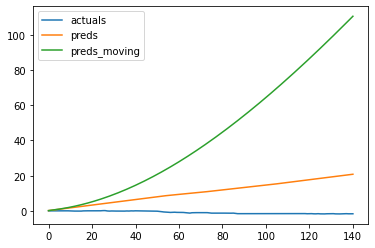

In [27]:

plt.plot(actuals.cumsum(),label = 'actuals')
plt.plot(preds.cumsum(),label='preds')
plt.plot(preds_moving.cumsum(),label = 'preds_moving')
plt.legend()
plt.show()
#plt.plot(GT_features[1282].cumsum() + GT[1282].iloc[1] )

#label axis 
# yellow line is positive 
# also plot tank level usage 

#benchmark why exploring single model (add to slides)
#what additional value for NN
# why the first predited value is different for yellow and green
# why two predicting methods differnt and valueable to explore 
# model accuracy, running time (slides )

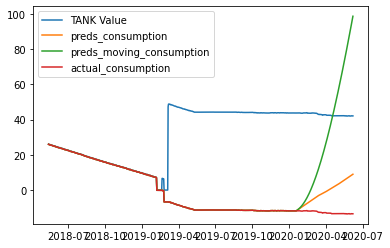

In [28]:
TANK_ID = 34508
CT_features_preds = CT_features.copy() 
CT_features_preds_moving = CT_features.copy() 

CT_features_preds[TANK_ID].iloc[nrow+window_size:] = preds.flatten()
CT_features_preds_moving[TANK_ID].iloc[nrow+window_size:] = preds_moving.flatten()

plt.plot(CT[TANK_ID], label = "TANK Value")
plt.plot(CT_features_preds[TANK_ID].cumsum() + CT[TANK_ID].iloc[1],label= "preds_consumption" )
plt.plot(CT_features_preds_moving[TANK_ID].cumsum()+ CT[TANK_ID].iloc[1],label = "preds_moving_consumption")
plt.plot(CT_features[TANK_ID].cumsum()+ CT[TANK_ID].iloc[1],label = "actual_consumption")

plt.legend()
plt.show()

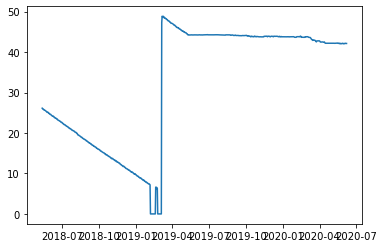

In [29]:
plt.plot(CT.iloc[:,4])

In [30]:
print(mean_squared_error(preds_moving,actuals))

0.7438185953046798


In [31]:
print(mean_squared_error(preds,actuals))

0.02886815865735868


In [32]:
print(mean_squared_error(preds,actuals))

0.02886815865735868


In [ ]:
# modeling for multiple tanks 
# decide metrics
# week 6 take rest of data to train:  1st: all time serites data to be trined 
#                                     2nd: attributes data included or not
#                                     3rd: decide metrics 
# week 7 refinement: document & testing; understanding data shape, features, etc 
# MA as basline to compare 

#Such as MA OF LAST 5 DAYS 
#COMMENT: Not only modeling, evaluating 
#tell a data story, present with wide range audience 
#gale the slides to common audience 
#frame story, less technich details
# take the knowledge I known, pretend it gone 
# go thourgh slides, pop up questions would be place to pay attention 
# Feynman Learnign Technique
# pretend you are teaching it to a student in  grade 6 (maybe to far)
# identify gaps in your explaination; go back to the source material, to better understand it 
# review and simplify 

# many tank (exact number) how value is a single model 
# videotape my presentation

# wait at least 4-10 weeks after intern 